# Model Selection and Hyperparameter Tuning

## Recap

Here's a machine learning model.

In [24]:
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

df = pd.read_csv("data/bordeaux.csv", index_col="year")
df_train = df.loc[:1980].copy()
df_test = df.loc[1981:].copy()

pipeline = make_pipeline(
    StandardScaler(),   # scaler
    KNeighborsRegressor(n_neighbors=5, metric="euclidean") # method, k, metric, 
)

X_train = df_train[["win", "summer"]] # variables
y_train = df_train["price"]

The right way to evaluate machine learning models is *test error,* which is estimated using cross-validation.

In [25]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    pipeline,
    X=X_train, y=y_train,
    scoring="neg_mean_squared_error",
    cv=4
)
-scores.mean()

np.float64(375.27166666666665)

How do we choose between all the options (scaler, $k$, etc.)?

## Two Related Problems

**Model Selection** refers to the choice of:
- which input features to include (e.g., winter rainfall, summer temperature)
- what preprocessing to do (e.g., scaler)
- what machine learning method to use (e.g. $k$-nearest neighbors)

**Hyperparameter Tuning** refers to the choice of parameters in the machine learning method. <br />
For $k$-nearest neighbors, hyperparameters include:
- $k$
- metric (e.g., Euclidean distance)

The distinction isn't important. We always use cross-validation and pick the model / hyperparameter with the smallest test error.


## Example of Model Selection

Which input features should we include?

- winter rain, summer temp
- winter rain, summer temp, harvest rain
- winter rain, summer temp, harvest rain, Sept. temp

In [26]:
for features in [["win", "summer"],
                 ["win", "summer", "har"],
                 ["win", "summer", "har", "sep"]]:
    scores = cross_val_score(
        pipeline,
        X=df_train[features],
        y=df_train["price"],
        scoring="neg_mean_squared_error",
        cv=4
    )
    # (winter rain, summer temp) is the best one
    print(features, -scores.mean())

['win', 'summer'] 375.27166666666665
['win', 'summer', 'har'] 363.04047619047617
['win', 'summer', 'har', 'sep'] 402.4507142857142


## Example of Hyperparameter Tuning

What is the best value of $k$?

In [27]:
X_train = df_train[["win", "summer", "har"]]
k_values, test_mses = range(1, 7),[]
for k in k_values:
    pipeline = make_pipeline(
        StandardScaler(),
        KNeighborsRegressor(n_neighbors=k, metric="euclidean")
    )
    
    scores = cross_val_score(
        pipeline, X_train, y_train,
        scoring="neg_mean_squared_error", cv=4)
    
    test_mses.append(-scores.mean())

<Axes: >

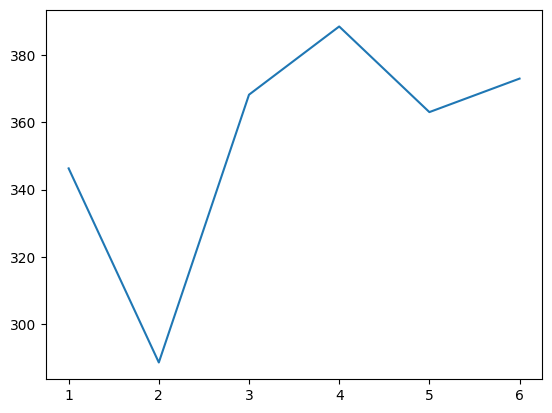

In [28]:
# The best value of k is 2
pd.Series(test_mses, index=k_values).plot.line()

## Training vs. Test Error

Here are the training and test MSEs on the same graph.

In [29]:
from sklearn.metrics import mean_squared_error

# get training score of the model
X_train = df_train[["win", "summer", "har"]]
y_train = df_train["price"]
k_values, training_mses = range(1, 7), []

for k in k_values:
    pipeline = make_pipeline(
        StandardScaler(),
        KNeighborsRegressor(n_neighbors=k, metric="euclidean")
    )
    score = mean_squared_error(y_train, pipeline.fit(X_train, y_train).predict(X_train))
    training_mses.append(score)

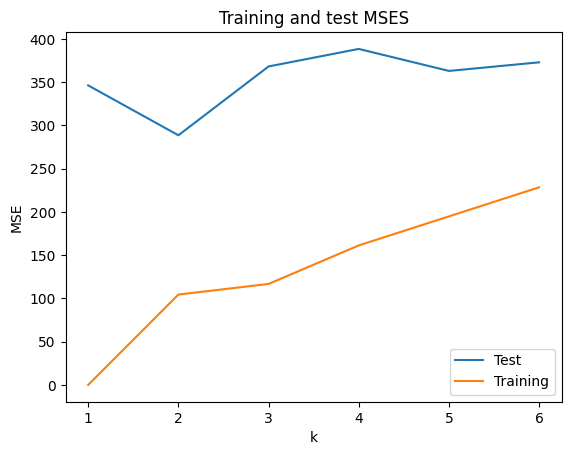

In [33]:
# visualize the training and test MSEs
import pandas as pd
import matplotlib.pyplot as plt

# create pandas series from the list
test_mses_series = pd.Series(test_mses, index=k_values, name='Test')
training_mses_series = pd.Series(training_mses, index=k_values, name='Training')

# plot the test MSEs
plt.plot(test_mses_series, label=test_mses_series.name)
plt.plot(training_mses_series, label=training_mses_series.name)

# add legend, title, labels
plt.legend(loc='lower right')
plt.title('Training and test MSES')
plt.xlabel('k')
plt.ylabel('MSE')

# show the plot
plt.show()

Notice that training MSE only goes down as we decrease $k$. <br />
If we optimize for training MSE, then we will pick $k = 1$, but this has worse test MSE. <br />
In other words, the $k = 1$ model has **overfit** to the training data.

## Grid Search

Suppose we want to choose $k$ and the distance metric (Euclidean or Manhattan).

We need to try all 12 combinations on the following grid:

![Grid](data/grid.png)

Scikit-Learn’s `GridSearchCV` automates the creation of a grid with all combinations.

## Grid Search in Scikit-Learn

Scikit-Learn can make a grid of the possible parameter combinations, run cross-validation for each combination, and return the best parameter combination.

In [34]:
pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=5, metric="manhattan"))

In [40]:
from sklearn.model_selection import GridSearchCV

grid_cv = GridSearchCV(
    pipeline,
    param_grid={
        "kneighborsregressor__n_neighbors": range(1, 7),
        "kneighborsregressor__metric": ["euclidean", "manhattan"],
    },
    scoring="neg_mean_squared_error", cv=4)

grid_cv.fit(X_train, y_train)
grid_cv.best_params_

{'kneighborsregressor__metric': 'euclidean',
 'kneighborsregressor__n_neighbors': 2}

Where did the parameter names in `param_grid` come from?

In [37]:
pipeline.steps

[('standardscaler', StandardScaler()),
 ('kneighborsregressor', KNeighborsRegressor(metric='manhattan'))]

## Challenges with Grid Search

**Why can’t all machine learning be automated by grid search?**

There were 5 input features in the original data (summer temp, harvest rainfall, winter rainfall, Sept. temperature, age). <br />
How many combinations of features would we need to try?

$2^5 = 32$

Now, combine this with the choice of k, distance metric, and scaler.
- 6 choices of k
- 2 choices of distance metric (Euclidean, Manhattan)
- 2 choices of scaler (StandardScaler, MinMaxScaler)

That’s already $32 \times 6 \times 2 \times 2 = 768$ models. <br />
And that’s not even considering models besides k-nearest neighbors!

## Heuristics for Parameter Tuning

For large data sets, it is impossible to try every combination of models and parameters.

So instead we use *heuristics*, which do not guarantee the best model but tend to work well in practice.

- **randomized search**: try random combinations of parameters, implemented in Scikit-Learn as `RandomizedSearchCV`.
- **coordinate optimization**:
    - start with guesses for all parameters,
    - try all values for *one* parameter (holding the rest constant) and find the best value of that parameter,
    - cycle through the parameters.
 